# Exercise 4: Ridge Regression on the Franke function with resampling (score 20 points)

Write your own code for the Ridge method, either using matrix inversion or the singular value decomposition as done in the previous exercise. Perform the same bootstrap analysis as in the Exercise 2 (for the same polynomials) and the cross-validation in exercise 3 but now for different values of λ. Compare and analyze your results with those obtained in exercises 1-3. Study the dependence on λ.

Study also the bias-variance trade-off as function of various values of the parameter λ. For the bias-variance trade-off, use the bootstrap resampling method. Comment your results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common import *
from sklearn import linear_model as lm
from sklearn.model_selection import cross_val_score, GridSearchCV
import os
#import seaborn as sns

print(f"Root directory: {os.getcwd()}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

%matplotlib inline 

Root directory: /home/arefrode/uio/fys-stk4155/projects/FYS-STK4155-Prj1_report/code


## 4.0 Data
Defining and creating the data


In [2]:
#generate some data:
np.random.seed(4155)
n = 20
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
x,y = np.meshgrid(x,y)
t_nonoise = FrankeFunction(x, y)
t = t_nonoise + noise_factor(n, factor=0.2)
degree = 15
min_lambda = -9
max_lambda = 4
nlambdas = 500
lambdas = np.logspace(min_lambda,max_lambda, nlambdas)

# 4.1 initial search landscape

In [3]:
test_mse = np.zeros((degree, nlambdas))
train_mse = np.zeros_like(test_mse)
model_list = np.empty_like(test_mse, dtype=object)
optimal_deg = 0
optimal_lmb = 0
lambda_degree = 0
best_mse = np.inf

for deg in range(1, degree+1):
    for lmb in range(len(lambdas)):

        X = create_X(x,y,n=deg)

        X_train, X_test, z_train, z_test = prepare_data(X, t.ravel(), 4155, scale_X=True, skip_intercept=True)

        model = RidgeRegression(lambdas[lmb])
        z_hat_train = model.fit(X_train, z_train)
        z_hat_test = model.predict(X_test)

        test_mse[deg-1,lmb] = MSE(z_test, z_hat_test)
        train_mse[deg-1, lmb] = MSE(z_train, z_hat_train)
        model_list[deg-1,lmb] = model
        
        if test_mse[deg-1,lmb] < best_mse:
            best_mse = test_mse[deg-1, lmb]
            optimal_deg = deg
            optimal_lmb = lambdas[lmb]
            lambda_degree = lmb

print(best_mse)
print(optimal_lmb)
print(optimal_deg)
print(train_mse[deg-1, lmb])
optimal_model = model_list[deg-1, lambda_degree]

0.14973420584785732
1e-09
6
0.16160047645498252


Surface-plot of optimal lambda

In [4]:
import matplotlib.ticker as mticker
%matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.title.set_text("Plot of the Search Landscape")
ax.set_xlabel("Polynomial degree"); ax.set_ylabel("Lambda index"); ax.set_zlabel("MSE")
#ax.set_yticklabels(f"{np.log10(lambdas[i])}" for i in np.linspace(0,499,6,dtype=int))
ax.set_xticklabels(f"{deg-2}" for deg in range(1, degree+3,2))

degs, lambs = np.meshgrid(range(degree), range(nlambdas))
print(degs.shape)
print(lambs.shape)
print(test_mse.shape)
surf = ax.plot_surface(degs, lambs, test_mse.swapaxes(0,1), cmap=cm.coolwarm)
ax.view_init(elev=14., azim=-58.)
ax.scatter(5, 0, best_mse, c='r', marker='o', s=100)
plt.savefig(f"{REPORT_FIGURES}{EX4}search_landscape_ridge.pdf")

Using matplotlib backend: TkAgg
(500, 15)
(500, 15)
(15, 500)


/tmp/ipykernel_15638/1424543159.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(f"{deg-2}" for deg in range(1, degree+3,2))


Betaplot showing effect of ridge

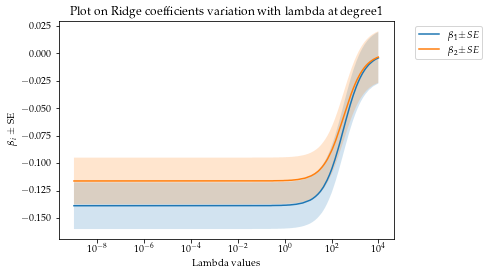

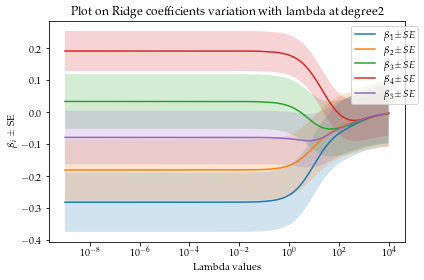

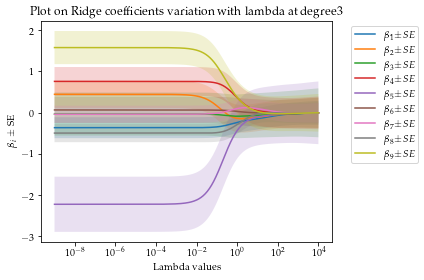

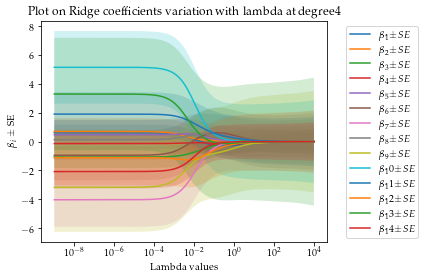

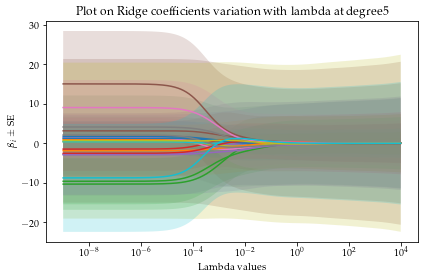

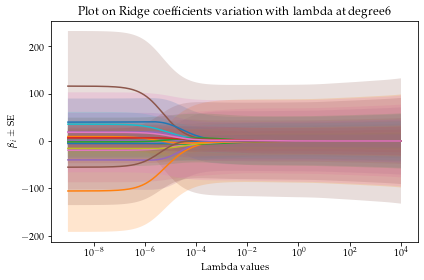

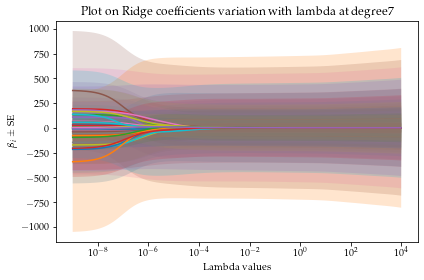

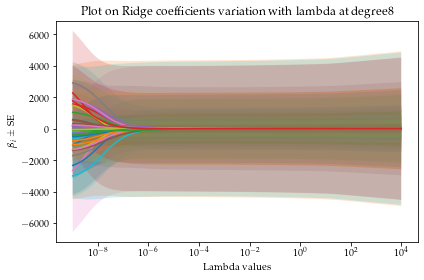

In [5]:
%matplotlib inline
for deg in range(1, degree-6):     # Only want the first 8
    summaries_df = pd.DataFrame()
    for lmb in lambdas:
        X = create_X(x,y,n=deg)
        X_train, X_test, z_train, z_test = prepare_data(X, t.ravel(), 4155, scale_X=True, skip_intercept=True)
        model = RidgeRegression(lmb)
        model.fit(X_train, z_train)
        summary_df = model.summary()
        summaries_df = pd.concat([summaries_df, summary_df], axis=0)

    fig = plot_beta_errors_for_lambdas(summaries_df, deg)
    plt.savefig(f"{REPORT_FIGURES}{EX4}beta_plot_ridge_{deg}.pdf")

Some code that implements the brute force lambda selection, this is inspired by the lecture 30.09

(320, 135)


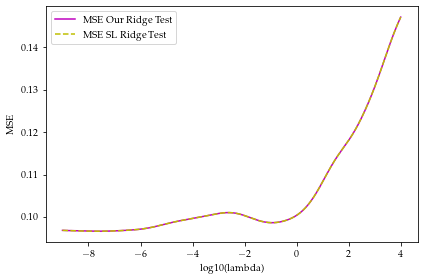

In [6]:
# NO NOISE

X = create_X(x,y,degree)
X_train, X_test, t_train, t_test = prepare_data(X,t_nonoise.ravel(),4155, scale_X=True, skip_intercept=True)

print(X_train.shape)

MSERidgePredict = np.zeros(nlambdas)
MSEOurRidge = np.zeros(nlambdas)
lambdas = np.logspace(min_lambda, max_lambda, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]

    # SKlearn
    RegRidge = lm.Ridge(lmb,fit_intercept=False) # ALWAYS keep intercept False
    RegRidge.fit(X_train, t_train)
    tpredictRidge = RegRidge.predict(X_test)
    MSERidgePredict[i] = MSE(t_test, tpredictRidge)

    # our Ridge
    model = RidgeRegression(lmb)
    model.fit(X_train, t_train)
    tpredictOur = model.predict(X_test)
    MSEOurRidge[i] = MSE(t_test, tpredictOur)

plt.figure()
plt.plot(np.log10(lambdas), MSEOurRidge, 'm', label = "MSE Our Ridge Test")
plt.plot(np.log10(lambdas), MSERidgePredict, 'y--', label = 'MSE SL Ridge Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

Comparing with gridSearch

model = lm.Ridge(fit_intercept=False)
gridsearch = GridSearchCV(estimator=model, param_grid=dict(alpha=lambdas))
gridsearch.fit(X_train, t_train)
print(gridsearch)
ypredictRidge = gridsearch.predict(X_test)
# summarize the results of the grid search
print(f"Best estimated lambda-value: {np.log10(gridsearch.best_estimator_.alpha)}")
print(f"MSE score: {MSE(t_test,ypredictRidge)}")
print(f"R2 score: {R2(t_test,ypredictRidge)}")

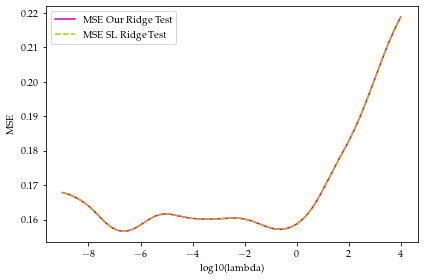

In [7]:
# NOISE and OLS for comparison

X = create_X(x,y,degree)
X_train, X_test, t_train, t_test = prepare_data(X,t.ravel(), 4155, scale_X=True, skip_intercept=True)

#X_train = X_train[:,1:]
#X_test = X_test[:,1:]

nlambdas = 500
MSERidgePredict = np.zeros(nlambdas)
MSEOurRidge = np.zeros(nlambdas)
MSEols = np.zeros(nlambdas)
lambdas = np.logspace(min_lambda, max_lambda, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]

    # SKlearn
    RegRidge = lm.Ridge(lmb,fit_intercept=False) # ALWAYS keep intercept False
    RegRidge.fit(X_train, t_train)
    tpredictRidge = RegRidge.predict(X_test)
    MSERidgePredict[i] = MSE(t_test, tpredictRidge)

    # our Ridge
    model = RidgeRegression(lmb)
    model.fit(X_train, t_train)
    tpredictOur = model.predict(X_test)
    MSEOurRidge[i] = MSE(t_test, tpredictOur)

    # OLS :)
    """
    ols = OLS()
    ols.fit(X_train, t_train)
    olspredict = ols.predict(X_test)
    MSEols[i] = MSE(t_test, olspredict)
    """

plt.figure()
plt.plot(np.log10(lambdas), MSEOurRidge, 'm', label = "MSE Our Ridge Test")
plt.plot(np.log10(lambdas), MSERidgePredict, 'y--', label = 'MSE SL Ridge Test')
#plt.plot(np.log10(lambdas), MSEols, 'b--', label = "MSE Our OLS Test")
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Bootstrapping
looping through a fewer set of lambda values, still from -9 to 4

In [8]:
np.random.seed(SEED_VALUE)
maxdegree = 13
n_bootstraps = 40
lmb = np.log10(1e-9)
n = 20
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
x,y = np.meshgrid(x,y)
z = FrankeFunction(x,y) + noise_factor(n, factor=0.05)

NameError: name 'SEED_VALUE' is not defined

In [ ]:
polydegree = np.arange(1, maxdegree+1)
MSE_test, MSE_train, bias, variance = bootstrap(x, y, z, maxdegree, n_bootstraps, RidgeRegression(lmb), scale_X=True, skip_intercept=True)

plt.plot(polydegree, MSE_test,"m", label='MSE test')
plt.plot(polydegree, MSE_train,"c", label='MSE train')
plt.plot(polydegree, bias,"b--", label='bias')
plt.plot(polydegree, variance,"r--", label='Variance')
#plt.plot(polydegree, bias+variance,"g--", label='bias+variance')

plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error - MSE")
plt.xticks(polydegree)
plt.grid(True)
plt.legend()
plt.savefig(f"{REPORT_FIGURES}{EX4}ridge_complexity_using_bootstrap_function.pdf")
plt.show()

Shouldn't OLS MSE for Noisy data be outperformed by Ridge?

In [ ]:
"""
for lmb in lambdas:
    boot_strp_MSE_test, _, _, boot_strp_variance = bootstrap(x, y, t, degree, 20, RidgeRegression(lmb))
    boot_strp_std = np.sqrt(boot_strp_variance)

    for degree in range(1,degree):
        X = create_X(x,y,degree)
    
    
        mean_folds_error = np.zeros(6)
        mse_std_arr = np.zeros(6)
        for folds in range(5,11):
            #create LinearRegression model object from SK to use in sk.cross_val_score
            sk_model = linear_model.Ridge(alpha=lmb)
            #Get scores from SK crossval:
            sk_scores = cross_val_score(sk_model, X, t.ravel(), cv=folds, scoring = "neg_mean_squared_error")
        

            implemented_scores = cross_val(k = folds, model = "Ridge",lmb=lmb, X = X, z = t, shuffle=True)
            # plt.plot(np.arange(1,folds+1), implemented_scores,"-o", label = f"Splitted in {folds} folds")
            # #plt.plot(np.arange(folds), sk_scores*-1,"--o", label = f"{folds} folds(sk.cv)")
            # plt.xlabel("MSE at testfold number")
            # plt.ylabel("MSE")
            # plt.title(f"Complexity degree: {degree} ")
            # plt.ylim(0,1)
            # plt.xticks(np.arange(1,folds+1))
            # plt.grid(True)
            # plt.legend()
            mean_folds_error[folds-5] = np.mean(implemented_scores)
            mse_std_arr[folds-5] = np.std(implemented_scores)
            
            
        #plt.errorbar(np.arange(5,11), mean_folds_error, yerr = mse_std_arr, fmt='c--', ecolor='deeppink', capthick=2)
        plt.plot(np.arange(5,11), np.ones(6)*boot_strp_MSE_test[degree],"o", label ="Mean MSE bootstrap with STD")
        plt.fill_between(np.arange(5,11), np.ones(6)*boot_strp_MSE_test[degree]-boot_strp_std[degree],
                        np.ones(6)*boot_strp_MSE_test[degree]+boot_strp_std[degree], alpha = 0.2 )
        plt.plot(np.arange(5,11), mean_folds_error, "o",  label = "Mean MSE CV with STD")
        plt.fill_between(np.arange(5,11), mean_folds_error-mse_std_arr, mean_folds_error+mse_std_arr,  alpha = 0.2, color = "darkorange")
        plt.title(f"Model complexity: {degree} degrees, log($\lambda$):{np.log10(lmb)} ")
        plt.xlabel("K-fold")
        plt.ylabel("MSE")
        plt.ylim(0,0.1)
        plt.xticks(np.arange(5,11))
        plt.grid(True)
        plt.legend()
        plt.show()
"""

## Looking at beta values for optimal degree

In [ ]:
"""
optimal_degree = 6
min_lambda = -7 
max_lambda = -3
nbf_lambdas = 20
lambdas = np.logspace(min_lambda,max_lambda, nbf_lambdas)
summaries_df = pd.DataFrame()

for lmb in lambdas:
    #MSE_test = np.zeros(maxdegree)
    #MSE_train = np.zeros(maxdegree)
    #polydegree = np.arange(maxdegree)
    #bias = np.zeros(maxdegree)
    #variance = np.zeros(maxdegree)

    X = create_X(x, y, n=optimal_degree)
    X_train, X_test, z_train, z_test = prepare_data(X, t.ravel().reshape(-1,1), test_size=0.2, shuffle=True, scale_X=True, scale_t=True, random_state=SEED_VALUE)
    model =  RidgeRegression(lambda_val=lmb)
    z_hat_train = model.fit(X_train, z_train, SVDfit=False, keep_intercept=False)        
    summary_df = model.summary()
    summaries_df = pd.concat([summaries_df,summary_df], axis=0)
    
fig = plot_beta_errors_for_lambdas(summaries_df, optimal_degree)
fig.savefig(f"{REPORT_FIGURES}{EX6_4}Ridge_beta_SE_for_lambdas.pdf")

fig = plot_beta_CI_for_lambdas(summaries_df, optimal_degree)
fig.savefig(f"{REPORT_FIGURES}{EX6_4}Ridge_beta_CI_for_lambdas.pdf")
"""

# OLD code!

## 2.3 - Finding optimal lambda for Ridge fit
First we find the optimal value for the lambda parameter by splitting the input data into training and test data. Than we fit the model using different values for lambda. For each lambda value we use the mean square error on the test data evaluate how god the fit is. The best lambda value is used to fit a new model with all data (not using train-test split). <br>
First we find the optimal parameter value of lambda, $\lambda$, by evaluating overfit from evaluation plot where we plot the values for MSE for training and test data

In [ ]:
nbf_lambdas = 10
lambdas = np.logspace(-5,5, nbf_lambdas)
z_train_ridge = pd.DataFrame()
z_hat_train_ridge = pd.DataFrame()
z_test_ridge = pd.DataFrame()
z_hat_test_ridge = pd.DataFrame()


z_hat_train_ridge_sk = pd.DataFrame()
z_hat_test_ridge_sk = pd.DataFrame()

for lmb in lambdas:
    model_sk = lm.Ridge(lmb, fit_intercept=False)
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False, random_state=4155)
    model = RidgeRegression(lmb) # The model
    model.fit(X_train, z_train) # Fitting the model

    # Fitting the scikit Ridge model
    model_sk.fit(X_train, z_train)
   
    # Predictions our Ridge model
    z_hat_train = model.predict(X_train) # predict on train data
    z_hat_test = model.predict(X_test) # predict on test data

    # Predictions sklearn Ridge
    z_hat_train_sk = model_sk.predict(X_train) # predict on train data
    z_hat_test_sk = model_sk.predict(X_test) # predict on test data

    # Filling up dataframes
    z_train_ridge[lmb] = z_train.flatten() 
    z_hat_train_ridge[lmb] = z_hat_train.flatten()
    z_test_ridge[lmb] = z_test.flatten()
    z_hat_test_ridge[lmb] = z_hat_test.flatten()

    # Filling up sk dataframes
    z_hat_train_ridge_sk[lmb] = z_hat_train_sk.flatten()
    z_hat_test_ridge_sk[lmb] = z_hat_test_sk.flatten()


# MSE calculations for all lambda values
mse_scores_train = ((z_train_ridge - z_hat_train_ridge) ** 2).mean()
mse_scores_test = ((z_test_ridge - z_hat_test_ridge) ** 2).mean()
mse_scors_train_sk = ((z_train_ridge - z_hat_train_ridge_sk) ** 2).mean()
mse_scores_test_sk = ((z_test_ridge - z_hat_test_ridge_sk) ** 2).mean()

# R2 calculations for all lambda values
R2_scores_train = 1 - ((z_train_ridge - z_hat_train_ridge) ** 2).sum() / ((z_train_ridge - z_train_ridge.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_ridge - z_hat_test_ridge) ** 2).sum() / ((z_test_ridge - z_test_ridge.mean())**2).sum()  

# Plots
plt.figure(figsize=(12,8))
plt.plot(-np.log(lambdas), mse_scores_train, label="Training data")
plt.plot(-np.log(lambdas), mse_scores_test, label="Test data")

plt.plot(-np.log(lambdas), mse_scors_train_sk, 'm--', label="Training data sklearn")
plt.plot(-np.log(lambdas), mse_scores_test_sk, 'y--', label="Test data sklearn")

#plt.plot(mse_scores_train,-np.log(lambdas), label="Training data")
#plt.plot(mse_scores_test,-np.log(lambdas), label="Test data")
plt.xlabel("log(lambda)")
plt.ylabel("MSE")
plt.title("Training evaluation on Ridge regression fit")
plt.legend()
plt.savefig(f"{REPORT_FIGURES}franke_function_Ridge_evaluate_fit.pdf")

Perform the same analysis as above, but with scaled data and fit intercept equal to false

In [ ]:
nbf_lambdas = 10
lambdas = np.logspace(-5,5, nbf_lambdas)
z_train_ridge = pd.DataFrame()
z_hat_train_ridge = pd.DataFrame()
z_test_ridge = pd.DataFrame()
z_hat_test_ridge = pd.DataFrame()


z_hat_train_ridge_sk = pd.DataFrame()
z_hat_test_ridge_sk = pd.DataFrame()

for lmb in lambdas:
    model_sk = lm.Ridge(lmb, fit_intercept=False)
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False, random_state=4155)
    model = RidgeRegression(lmb) # The model
    model.fit(X_train, z_train) # Fitting the model

    # Fitting the scikit Ridge model
    model_sk.fit(X_train, z_train)
   
    # Predictions our Ridge model
    z_hat_train = model.predict(X_train) # predict on train data
    z_hat_test = model.predict(X_test) # predict on test data

    # Predictions sklearn Ridge
    z_hat_train_sk = model_sk.predict(X_train) # predict on train data
    z_hat_test_sk = model_sk.predict(X_test) # predict on test data

    # Filling up dataframes
    z_train_ridge[lmb] = z_train.flatten() 
    z_hat_train_ridge[lmb] = z_hat_train.flatten()
    z_test_ridge[lmb] = z_test.flatten()
    z_hat_test_ridge[lmb] = z_hat_test.flatten()

    # Filling up sk dataframes
    z_hat_train_ridge_sk[lmb] = z_hat_train_sk.flatten()
    z_hat_test_ridge_sk[lmb] = z_hat_test_sk.flatten()


# MSE calculations for all lambda values
mse_scores_train = ((z_train_ridge - z_hat_train_ridge) ** 2).mean()
mse_scores_test = ((z_test_ridge - z_hat_test_ridge) ** 2).mean()
mse_scors_train_sk = ((z_train_ridge - z_hat_train_ridge_sk) ** 2).mean()
mse_scores_test_sk = ((z_test_ridge - z_hat_test_ridge_sk) ** 2).mean()

# R2 calculations for all lambda values
R2_scores_train = 1 - ((z_train_ridge - z_hat_train_ridge) ** 2).sum() / ((z_train_ridge - z_train_ridge.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_ridge - z_hat_test_ridge) ** 2).sum() / ((z_test_ridge - z_test_ridge.mean())**2).sum()  

# Plots
plt.figure(figsize=(12,8))
plt.plot(-np.log(lambdas), mse_scores_train, label="Training data")
plt.plot(-np.log(lambdas), mse_scores_test, label="Test data")

plt.plot(-np.log(lambdas), mse_scors_train_sk, 'm--', label="Training data sklearn")
plt.plot(-np.log(lambdas), mse_scores_test_sk, 'y--', label="Test data sklearn")

#plt.plot(mse_scores_train,-np.log(lambdas), label="Training data")
#plt.plot(mse_scores_test,-np.log(lambdas), label="Test data")
plt.xlabel("log(lambda)")
plt.ylabel("MSE")
plt.title("Training evaluation on Ridge regression fit")
plt.legend()
plt.savefig(f"{REPORT_FIGURES}franke_function_Ridge_evaluate_fit.pdf")

# 2.3.1
Finding the optimal lambda by using the bootstrap resampling technique over different values of lamda. For each value of lambda, a bias-variance tradeoff chart as in exercise 2 is created. 

In [ ]:
n_bootstraps = 100
maxdegree = 12
for lmb in lambdas:
    MSE_test = np.zeros(maxdegree)
    MSE_train = np.zeros(maxdegree)
    polydegree = np.arange(maxdegree)
    bias = np.zeros(maxdegree)
    variance = np.zeros(maxdegree)

    for degree in tqdm(range(maxdegree), desc = f"Looping through polynomials up to {maxdegree} degrees with {n_bootstraps} bootstraps: "):
        model = RidgeRegression(lmb)
        X = create_X(x, y, n=degree)
        X_train, X_test, z_train, z_test = prepare_data(X, z)

        # Reshape for broadcasting
        z_test_ = np.reshape(z_test, newshape=(z_test.shape[0],1))
        z_train_ = np.reshape(z_train, newshape=(z_train.shape[0],1))
        
        # Scaling data and preparing output arrays 
        scaler = StandardScaler()
        scaler.fit(X_train)
        #X_train_scaled = scaler.transform(X_train)
        #X_test_scaled = scaler.transform(X_test)
        z_pred = np.empty((z_test.shape[0], n_bootstraps))
        z_fit = np.empty((z_train.shape[0], n_bootstraps))

        # Bootstrapping
        for i in range(n_bootstraps):
            x_, z_ = resample(X_train, z_train)
            model.fit(X_train, z_train)
            z_pred[:,i] = model.predict(X_test)
            z_fit[:,i] = model.predict(X_train)

        MSE_test[degree] = np.mean( np.mean((z_test_ - z_pred)**2, axis=1, keepdims=True) )
        MSE_train[degree] = np.mean( np.mean((z_train_ - z_fit)**2, axis=1, keepdims=True) )
        bias[degree] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True))

    plt.figure()
    plt.plot(polydegree, MSE_test,"m", label='MSE\_test')
    plt.plot(polydegree, MSE_train,"c", label='MSE\_train')

    plt.plot(polydegree, bias,"g--", label='bias')
    plt.plot(polydegree, variance,"r--", label='Variance')

    plt.title(f"Bias-Variance for log10(lambda) = {np.log10(lmb)}")
    plt.xlabel("Model complexity / Polynomial Degree")
    plt.ylabel("Prediction Error")

    plt.grid(True)
    plt.legend()
    plt.show()

    display(model.summary())
      


## 2.4 Analysis of plots and training metrics
Do the analysis.......

Conclusion:<br>
Based on the analysis, we conclude that a model complexity of degree 5 yields the most optimal fit.

## 2.5 plot of the model using the most optimal parameters

In [ ]:
scale = False

if scale:
    # Data Scalling
    X_scaler = StandardScaler()
    X_scaler.fit(X)
    X_train = X_scaler.transform(X_train)
    z_train = np.expand_dims(z,axis=1)  
    z_scaler = StandardScaler()
    z_scaler.fit(z_train)
    z_train = z_scaler.transform(z_train)
else:
    X_train = X; z_train = z

lam = -1.1
model = RidgeRegression(lam) # The model
model.fit(X_train, z_train) # Fitting the model
z_hat = model.predict(X_train) # predict on train data

# Evaluatation metrics
# TODO:
results_df = pd.DataFrame(columns=["MSE", "R2-score"], index=["Training data", "Test data"])
results_df["MSE"] = MSE(z, z_hat)
results_df["R2-score"] = R2(z, z_hat)
results_df.to_csv(f"{REPORT_DATA}redge_reg_lambda_{lam}.csv")

# Plot
fig = plt.figure()#figsize=(8,8))
ax = plt.axes(projection='3d')
ax.title.set_text(f"Ridge regression fit to the Franke Function\nDegree {degree},$\lambda$:{lam}")
#ax.view_init(elev=5., azim=85.0)
ax.view_init(elev=30., azim=-25.0)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.scatter3D(x,y,z,c=z, cmap=cm.coolwarm, marker = '.')
plt.savefig(f"{REPORT_FIGURES}franke_function_Ridge_best_fit.pdf")